In [1]:
import numpy as np
import sys
import os

In [2]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [3]:
sys.path.append(os.path.abspath(os.path.join(".", "..")))
import bssneqs as bssn
import bssnutils as butil
import tomllib
from nwave import *

In [4]:
inputstring = """
# This is a sample input file for the BSSN code.
Nt = 12
Nx =  1500
Xmin =-100.0
Xmax = 100.0

NGhost = 3
cfl = 0.15
eta = 2.0

D1 = ["JP6", "ME6"]
D2 = ["JP6", "ME6"]
DerivSolveMethod = "SCIPY"

BHMask = true
BHMaskPos = 0.0
BHMaskWidth = 0.02

Filter = "F2"
FilterKOsigma = 0.5
FilterBoundary = true
FilterApply = "Vars"
FilterFrequency = 10
FilterAlpha = 0.4

# initial data types = [ "Puncture", "EddingtonFinkelstein" ]
Mass = 1.0
collapsed_lapse = false
initial_data = "Puncture"

# output parameters
output_dir = "output_bssn"
output_interval = 50
print_interval = 5
"""
params = tomllib.loads(inputstring)

In [5]:
# Set up grid
if "Xmin" in params and params["Xmin"] < 0.0:
    extended_domain = True
    cellgrid = False
    if params["Nx"] % 2 != 0:
        params["Nx"] += 1
        print(f"Adjusted Nx to {params['Nx']} (must be even)")
else:
    extended_domain = False
    cellgrid = True

nghost = params["NGhost"]
g = Grid1D(params, cell_centered=cellgrid)
r = g.xi[0]

In [6]:
D1, D2 = butil.init_derivative_operators(r, params)
g.set_D1(D1)
g.set_D2(D2)
print(f"D1 type: {g.D1.get_type()}")
print(f"D2 type: {g.D2.get_type()}")

init_derivative_operators>>  d1_param = ['JP6', 'ME6']
init_derivative_operators>>  d2_param = ['JP6', 'ME6']
init_derivative_operators>>  d1_list = ['JP6', 'ME6']
init_derivative_operators>>  mask_bh  = True
init_derivative_operators>> Setting BH Masked derivative for D1. Background type: DerivType.D1_JP6, BH type: DerivType.D1_ME642
init_derivative_operators>> BH Mask. position: 0.0, width: 0.02
init_derivative_operators>> Setting BH Masked derivative for D2. Background type: DerivType.D2_JP6, BH type: DerivType.D2_ME642
D1 type: DerivType.D1_JP6
D2 type: DerivType.D2_JP6


In [7]:
F1 = butil.init_filter(r, params)
g.set_filter(F1)

if g.num_filters > 0:
    for f in g.Filter:
        print(f"f type = {type(f)}")
        print(f"Filter type: {f.get_filter_type()}")
        print(f"Filter apply: {f.get_apply_filter()}")

init_filter>> Creating BH masked filter: Background type: FilterType.F2, apply: FilterApply.APPLY_VARS, method: CFDSolve.SCIPY
init_derivative_operators>> BH Mask. position: 0.0, width: 0.02
pbands = (1, 1)
pbounds = [array([1. , 0.4])]
pbands = (1, 1)
pbounds = [array([1., 0.]), array([0.4, 1. , 0.4])]
f type = <class 'nwave.cf.NCompactFilter'>
Filter type: FilterType.F2
Filter apply: FilterApply.APPLY_VARS


In [8]:
# GBSSN system: (sys, lapse advection, shift advection)
#    sys = 0 (Eulerian), 1 (Lagrangian)
sys = bssn.GBSSNSystem(1, 1, 1)
eqs = bssn.BSSN(
    g, params["Mass"], params["eta"], extended_domain, "FUNCTION", sys, have_d2=True
)
eqs.initialize(g, params)

In [9]:
eqs.cal_constraints(eqs.u, g)

In [10]:
d_chi = D1.grad(eqs.u[eqs.U_CHI])
d_g_rr = D1.grad(eqs.u[eqs.U_GRR])
d_g_tt = D1.grad(eqs.u[eqs.U_GTT])
d_A_rr = D1.grad(eqs.u[eqs.U_ARR])
d_K = D1.grad(eqs.u[eqs.U_K])
d2_chi = D2.grad(eqs.u[eqs.U_CHI])
d2_g_tt = D2.grad(eqs.u[eqs.U_GTT])
d_alpha = D1.grad(eqs.u[eqs.U_ALPHA])
d2_alpha = D2.grad(eqs.u[eqs.U_ALPHA])
Gt = eqs.u[eqs.U_GT]
d_Gt = D1.grad(Gt)

In [11]:
# our custom event handler
def update_trace(trace, points, selector):
    # this list stores the points which were clicked on
    # in all but one trace they are empty
    if len(points.point_inds) == 0:
        return          
    for i,_ in enumerate(fig.data):
        fig.data[i]['line']['width'] = default_linewidth + highlighted_linewidth_delta * (i == points.trace_index)

default_linewidth = 2
highlighted_linewidth_delta = 2

fig = go.FigureWidget()
fig.layout.hovermode = 'closest'
fig.layout.hoverdistance = -1 #ensures no "gaps" for selecting sparse data
fig.add_trace(go.Scatter(x=r, y=Gt, name="Gt", mode="lines+markers",line={ 'width': default_linewidth }))
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers", line={ 'width': default_linewidth }))
# we need to add the on_click event to each trace separately       
for i in range( len(fig.data) ):
    fig.data[i].on_click(update_trace)

# Layout with log scale option
fig.update_layout(
    title='Gt and dx_Gt',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    yaxis_range=[-5,5],
    hovermode='x',
    template='plotly_white'
)

fig.show()

FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'Gt',
              'type': 'scatter',
              'uid': '38b3637e-cdd1-4282-a116-bd43c15bb963',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('OjU5aPpllD9iEtpI7WyUP+kvDefkc5' ... '8N5+RzlL9jEtpI7WyUvzo1OWj6ZZS/'),
                    'dtype': 'f8'}},
             {'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'd_Gt',
              'type': 'scatter',
              'uid': '39cabd81-fc3d-48b0-ae33-0e47fbeeadca',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('IFfN9jRoKD9eOWjGilsqP3gVDTvKCC' ... 'MNO8oIKj8kPGjGilsqP3VczfY0aCg/'),
                    'dtype': 'f8'}}],
    'layout': {'hoverdistance': -1

In [12]:

default_linewidth = 2
highlighted_linewidth_delta = 2

fig = go.FigureWidget()
fig.layout.hovermode = 'closest'
fig.layout.hoverdistance = -1  # Avoid gaps in click registration

fig.add_trace(go.Scatter(x=r, y=Gt, name="Gt", mode="lines+markers", line={'width': default_linewidth}))
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers", line={'width': default_linewidth}))

# A single shared handler
def shared_click_handler(trace, points, selector):
    if not points.point_inds:
        return
    clicked_trace_index = points.trace_index
    for i, trace in enumerate(fig.data):
        trace.line.width = (
            default_linewidth + highlighted_linewidth_delta if i == clicked_trace_index else default_linewidth
        )

# Register shared handler to just one trace (doesn't matter which)
# It will still be called on clicks to *any* trace
for trace in fig.data:
    trace.on_click(shared_click_handler)

# Layout
fig.update_layout(
    title='Gt and d_Gt',
    xaxis=dict(title='x', type='linear'),
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    yaxis_range=[-5,5],
    hovermode='x',
    template='plotly_white'
)

fig


FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'Gt',
              'type': 'scatter',
              'uid': 'd2a0a9f4-abfa-4ced-bf03-24117c7f7b61',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('OjU5aPpllD9iEtpI7WyUP+kvDefkc5' ... '8N5+RzlL9jEtpI7WyUvzo1OWj6ZZS/'),
                    'dtype': 'f8'}},
             {'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'd_Gt',
              'type': 'scatter',
              'uid': '492f9341-e54d-4329-a622-42663dabc03b',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('IFfN9jRoKD9eOWjGilsqP3gVDTvKCC' ... 'MNO8oIKj8kPGjGilsqP3VczfY0aCg/'),
                    'dtype': 'f8'}}],
    'layout': {'hoverdistance': -1

In [13]:
# Plot setup
default_linewidth = 2
highlighted_linewidth_delta = 2

fig = go.FigureWidget()
fig.add_trace(go.Scatter(x=r, y=Gt, name="Gt", mode="lines+markers", line={'width': default_linewidth}))
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers", line={'width': default_linewidth}))

fig.update_layout(
    title='Gt and d_Gt',
    xaxis=dict(title='x', type='linear'),
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    yaxis_range=[-5,5],
    hovermode='x',
    template='plotly_white'
)

# Buttons to simulate trace selection
selector = widgets.ToggleButtons(
    options=[('None', -1), ('Gt', 0), ('d_Gt', 1)],
    description='Highlight:',
    style={'button_color': '#ddd'}
)

def on_select(change):
    selected = change['new']
    for i, trace in enumerate(fig.data):
        trace.line.width = (
            default_linewidth + highlighted_linewidth_delta if i == selected else default_linewidth
        )

selector.observe(on_select, names='value')

# Display
display(selector, fig)

ToggleButtons(description='Highlight:', options=(('None', -1), ('Gt', 0), ('d_Gt', 1)), value=-1)

FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'Gt',
              'type': 'scatter',
              'uid': 'f1c0f15a-fb65-4bd0-9873-b3bb1d63725a',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('OjU5aPpllD9iEtpI7WyUP+kvDefkc5' ... '8N5+RzlL9jEtpI7WyUvzo1OWj6ZZS/'),
                    'dtype': 'f8'}},
             {'line': {'width': 2},
              'mode': 'lines+markers',
              'name': 'd_Gt',
              'type': 'scatter',
              'uid': '65aad852-676d-47ec-9adb-4ef807266c2f',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('IFfN9jRoKD9eOWjGilsqP3gVDTvKCC' ... 'MNO8oIKj8kPGjGilsqP3VczfY0aCg/'),
                    'dtype': 'f8'}}],
    'layout': {'hovermode': 'x',
 

In [14]:
default_linewidth = 2
highlighted_linewidth_delta = 2

fig = go.FigureWidget()
fig.layout.hovermode = 'closest'
fig.layout.hoverdistance = -1

fig.add_trace(go.Scatter(x=r, y=Gt, name="Gt", mode="lines", line={'width': default_linewidth}))
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines", line={'width': default_linewidth}))

# Track highlighted line index
highlighted_index = {'value': None}  # Mutable so it can be changed inside the closure

# Single handler factory
def make_handler(my_index):
    def update_trace(trace, points, selector):
        if not points.point_inds:
            return
        # Update all line widths
        for i in range(len(fig.data)):
            fig.data[i].line.width = (
                default_linewidth + highlighted_linewidth_delta if i == my_index else default_linewidth
            )
        highlighted_index['value'] = my_index
    return update_trace

# Attach the handler using closure
for i in range(len(fig.data)):
    fig.data[i].on_click(make_handler(i))

# Layout
fig.update_layout(
    title='Gt and d_Gt',
    xaxis=dict(title='x', type='linear'),
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    yaxis_range=[-5,5],
    hovermode='x',
    template='plotly_white'
)

fig

FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines',
              'name': 'Gt',
              'type': 'scatter',
              'uid': '81394ff2-419c-468c-b7f2-d671b8f08a5e',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('OjU5aPpllD9iEtpI7WyUP+kvDefkc5' ... '8N5+RzlL9jEtpI7WyUvzo1OWj6ZZS/'),
                    'dtype': 'f8'}},
             {'line': {'width': 2},
              'mode': 'lines',
              'name': 'd_Gt',
              'type': 'scatter',
              'uid': '0834379f-d214-4e28-9f2c-fa70ba0444fc',
              'x': {'bdata': ('ksTT+J0ZWcBh2Df7ExFZwDHsm/2JCF' ... 'yb/YkIWUBg2Df7ExFZQJLE0/idGVlA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('IFfN9jRoKD9eOWjGilsqP3gVDTvKCC' ... 'MNO8oIKj8kPGjGilsqP3VczfY0aCg/'),
                    'dtype': 'f8'}}],
    'layout': {'hoverdistance': -1,
              

In [15]:
dr = r[1] - r[0]  # grid spacing
ED1 = ExplicitFirst642_1D(dr)
ED2 = ExplicitSecond642_1D(dr)

In [16]:
ed_chi = ED1.grad(eqs.u[eqs.U_CHI])
ed_g_rr = ED1.grad(eqs.u[eqs.U_GRR])
ed_g_tt = ED1.grad(eqs.u[eqs.U_GTT])
ed_A_rr = ED1.grad(eqs.u[eqs.U_ARR])
ed_K = ED1.grad(eqs.u[eqs.U_K])
ed2_chi = ED2.grad(eqs.u[eqs.U_CHI])
ed2_g_tt = ED2.grad(eqs.u[eqs.U_GTT])
ed_Gt = ED1.grad(Gt)

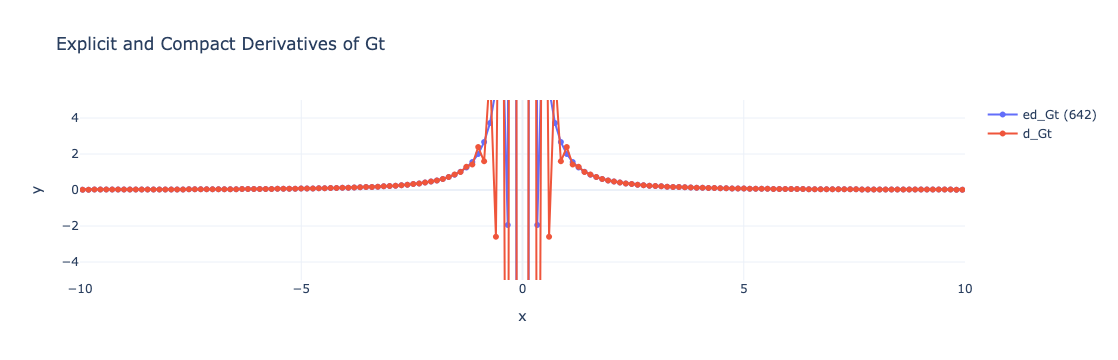

In [17]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x=r, y=ed_Gt, name="ed_Gt (642)", mode="lines+markers"))
#fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=ed_Gt, name="ed_Gt (642)", mode="lines+markers",hoverinfo='skip'))
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers",hoverinfo='skip'))

# we need to add the on_click event to each trace separately       
for i in range( len(fig.data) ):
    fig.data[i].on_click(update_trace)

# Layout with log scale option
fig.update_layout(
    title='Explicit and Compact Derivatives of Gt',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-10,10],
    yaxis_range=[-5,5],
    hovermode='x',
    template='plotly_white'
)

fig.show()

In [18]:
f = eqs.u[eqs.U_GT]
amp = 1.0e-1
#fn = f + amp*np.sin(137.523*r)
gn = np.random.normal(0, 0.1, len(r))
fn = f + amp*gn
fbounds = False
CF_F2 = NCompactFilter.init_filter(r, FilterType.F2, FilterApply.APPLY_VARS, CFDSolve.SCIPY, 1, fbounds, 0.4)
CF_JTT4 = NCompactFilter.init_filter(r, FilterType.JTT4, FilterApply.APPLY_VARS, CFDSolve.SCIPY, 1, fbounds, 0.4)
CF_JTT6 = NCompactFilter.init_filter(r, FilterType.JTT6, FilterApply.APPLY_VARS, CFDSolve.SCIPY, 1, fbounds, 0.4)
CF_JTP6 = NCompactFilter.init_filter(r, FilterType.JTT6, FilterApply.APPLY_VARS, CFDSolve.SCIPY, 1, fbounds, 0.4, beta=0.4)
f_F2 = CF_F2.filter(fn)
f_JTT4 = CF_JTT4.filter(fn)
f_JTT6 = CF_JTT6.filter(fn)
f_JTP6 = CF_JTP6.filter(fn)

pbands = (1, 1)
pbounds = [array([1.])]
pbands = (1, 1)
pbounds = [array([1.]), array([0., 1.])]
pbands = (1, 1)
pbounds = [array([1.])]
pbands = (1, 1)
pbounds = [array([1.])]


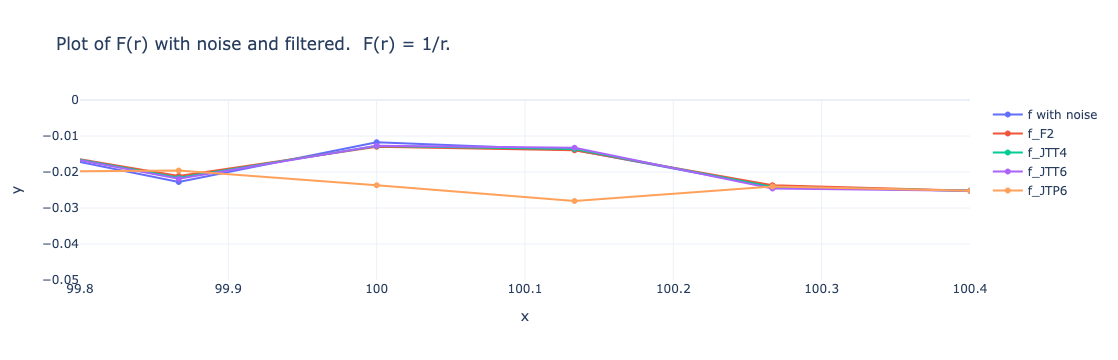

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=fn, name="f with noise", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_F2, name="f_F2", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_JTT4, name="f_JTT4", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_JTT6, name="f_JTT6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_JTP6, name="f_JTP6", mode="lines+markers"))
fig.update_layout(
    title='Plot of F(r) with noise and filtered.  F(r) = 1/r.',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[99.8,100.4],
    yaxis_range=[-0.05,0],
    hovermode='x',
    template='plotly_white'
)

In [20]:
Gtf = CF_JTT6.filter(Gt)
d_Gtf = D1.grad(Gtf)

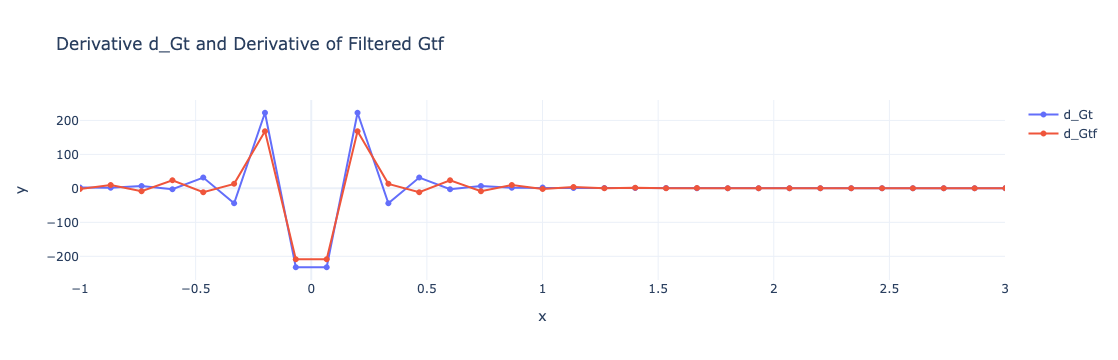

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=d_Gt, name="d_Gt", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=d_Gtf, name="d_Gtf", mode="lines+markers"))
fig.update_layout(
    title='Derivative d_Gt and Derivative of Filtered Gtf',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    hovermode='x',
    template='plotly_white'
)

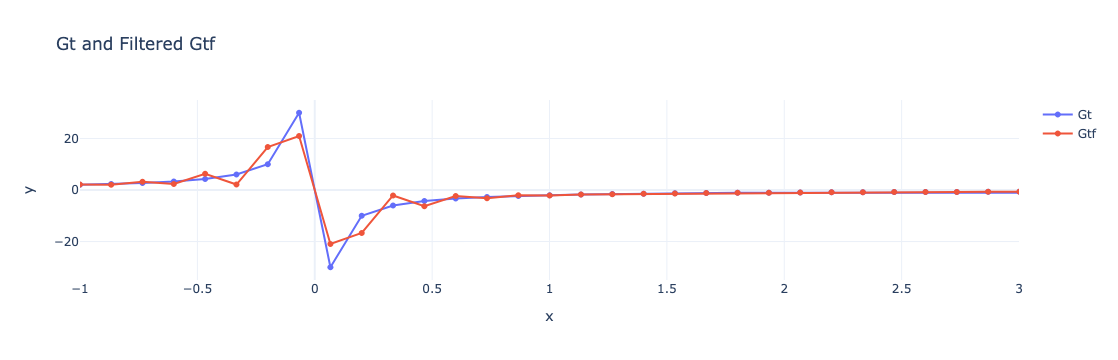

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=Gt, name="Gt", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=Gtf, name="Gtf", mode="lines+markers"))
fig.update_layout(
    title='Gt and Filtered Gtf',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    hovermode='x',
    template='plotly_white'
)

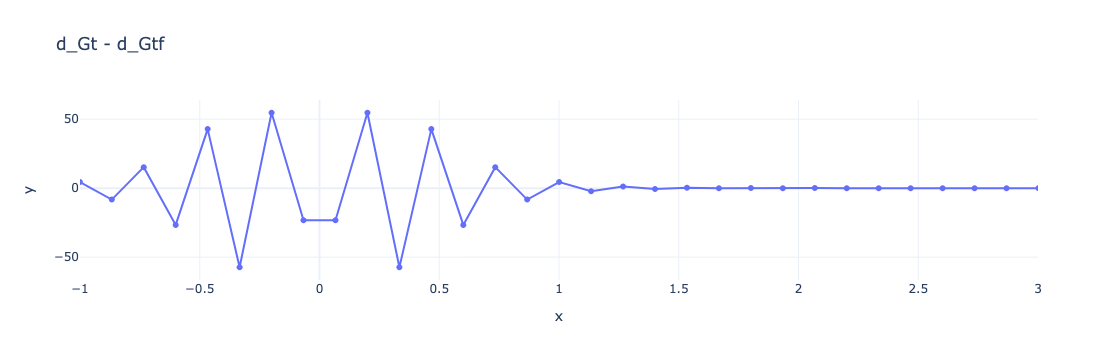

In [23]:
dd = d_Gt - d_Gtf
fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=dd, name="Diff d_Gt", mode="lines+markers"))

fig.update_layout(
    title='d_Gt - d_Gtf',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,3],
    hovermode='x',
    template='plotly_white'
)

In [24]:
fbounds = False
sigma = 0.4
CKO_JTT6 = NCompactFilter.init_filter(r, FilterType.JTT4, FilterApply.RHS, CFDSolve.LUSOLVE, 1, fbounds, 0.0, ko_sigma=sigma)
CKO_JTT6 = NCompactFilter.init_filter(r, FilterType.JTT6, FilterApply.RHS, CFDSolve.LUSOLVE, 1, fbounds, 0.4, ko_sigma=sigma)
CKO_JTP6 = NCompactFilter.init_filter(r, FilterType.JTP6, FilterApply.RHS, CFDSolve.LUSOLVE, 1, fbounds, 0.4, beta=0.2, ko_sigma=sigma)
KO6_filter = KreissOligerFilterO6_1D(dr, sigma, filter_boundary=fbounds)

pbands = (1, 1)
pbounds = [array([1.]), array([0., 1.])]
pbands = (1, 1)
pbounds = [array([1.])]
pbands = (2, 2)
pbounds = [array([1.]), array([0., 1.])]


In [25]:
# The Kim filter is broken as called here.
#CKO_KIM = CompactFilter(r, FilterApply.APPLY_VARS, FilterType.KP4,1,0.4,0.4,0.88,0.25, True)
#df_kim = CKO_KIM.filter(fn)

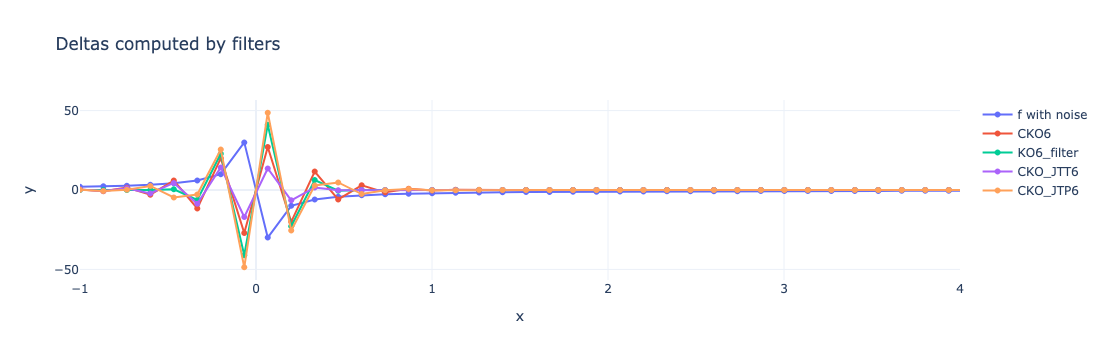

In [26]:
df_cko = CKO_JTT6.filter(fn)
df_ko = KO6_filter.filter(fn)
df_ckot = CKO_JTT6.filter(fn)
df_ckop = CKO_JTP6.filter(fn)

fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=fn, name="f with noise", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=df_cko, name="CKO6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=df_ko, name="KO6_filter", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=df_ckot, name="CKO_JTT6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=df_ckop, name="CKO_JTP6", mode="lines+markers"))

#fig.add_trace(go.Scatter(x=r, y=df_kim, name="CKO_KIM", mode="lines+markers"))

fig.update_layout(
    title='Deltas computed by filters',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,4],
    #yaxis_range=[-0.1,0.1],
    hovermode='x',
    template='plotly_white'
)

fig.show()

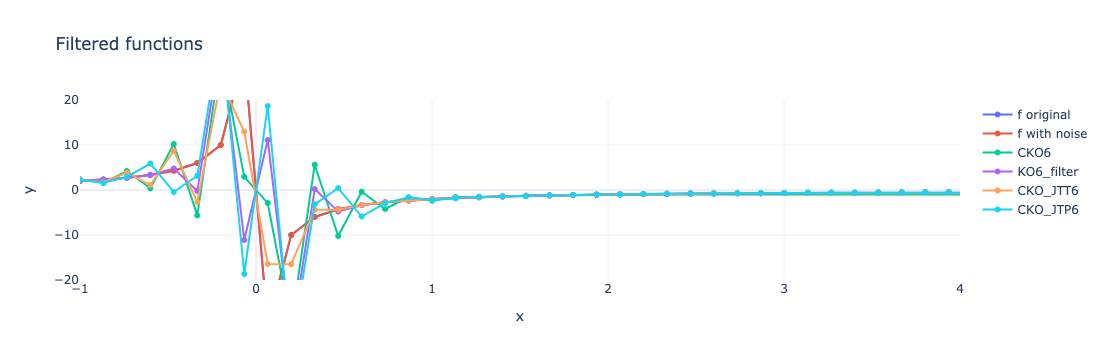

In [27]:
f_cko = fn + df_cko
f_ko = fn + df_ko
f_ckot = fn + df_ckot
f_ckop = fn + df_ckop


fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=f, name="f original", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=fn, name="f with noise", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_cko, name="CKO6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_ko, name="KO6_filter", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_ckot, name="CKO_JTT6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=f_ckop, name="CKO_JTP6", mode="lines+markers"))
#fig.add_trace(go.Scatter(x=r, y=f_kim, name="CKO_KIM", mode="lines+markers"))

fig.update_layout(
    title='Filtered functions',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,4],
    yaxis_range=[-20,20],
    hovermode='x',
    template='plotly_white'
)

fig.show()

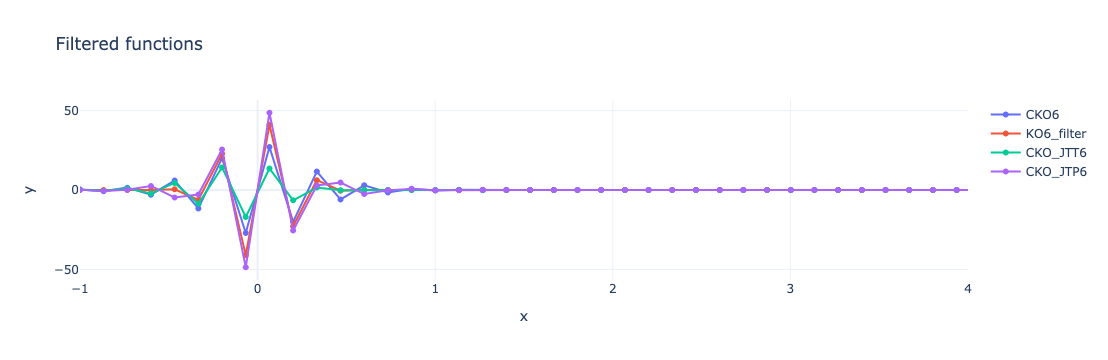

In [31]:
del_cko = f_cko - f
del_ko = f_ko - f
del_ckot = f_ckot - f
del_ckop = f_ckop - f

fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=del_cko, name="CKO6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=del_ko, name="KO6_filter", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=del_ckot, name="CKO_JTT6", mode="lines+markers"))
fig.add_trace(go.Scatter(x=r, y=del_ckop, name="CKO_JTP6", mode="lines+markers"))
#fig.add_trace(go.Scatter(x=r, y=f_kim, name="CKO_KIM", mode="lines+markers"))

fig.update_layout(
    title='Filtered functions',
    xaxis=dict(title='x', type='linear'),  # use 'log' for log scale
    yaxis=dict(title='y'),
    xaxis_range=[-1,4],
    #yaxis_range=[-20,20],
    hovermode='x',
    template='plotly_white'
)

fig.show()

In [30]:
#CKO_KIM.get_A()